New York Institute of Technology<br>
Course: DTSC 870 / Spring 2022<br>
Advisor: Dr. Cao<br>
Team: Michael Trzaskoma, Hui (Henry) Chen

----

This notebook is for the MRI tumor image classification (binary) model of the project. Therefore, this is part of Phase I of the project.

For more info, please visit the SVM pratical guide: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

Switch the Notebook runtime to GPU then check the available GPU.

# Set up

In [ ]:
# setup to see the execution time in each cell

!pip install ipython-autotime
!pip install directory_structure
!curl https://colab.chainer.org/install | sh -
%load_ext autotime

     |████████████████████████████████| 175 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=98b7fe94f69637aed9895bd3118303a191d63d7a9d6999758960f0e1a992c6fa
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   9634      0 --:--:-- --:--:-- --:--:--  9693
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
+ p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 19.9 s (started: 2022-05-10 01:25:11 +00:00)


In [ ]:
import pandas as pd
import os
import glob
import PIL
from PIL import Image
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

time: 2.14 s (started: 2022-05-10 01:25:33 +00:00)


### No Img Aug

In [ ]:
# ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# # ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

# DATASET_01 = ROOT_DIR + "/datasets/01_MRI/Brain_tumor_images"
# DATASET_01_TRAIN = DATASET_01 + "/train"
# DATASET_01_TEST = DATASET_01 + "/test"

time: 10.2 ms (started: 2022-05-10 01:25:37 +00:00)


### Img Aug

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

DATASET_01 = ROOT_DIR + "/datasets/01_MRI"
DATASET_01_TRAIN = DATASET_01 + "/Aug_train"
DATASET_01_TEST = DATASET_01 + "/Aug_test"

time: 11.7 ms (started: 2022-05-10 02:51:00 +00:00)


In [ ]:
from directory_structure import Tree

os.chdir(DATASET_01)
print(Tree(os.getcwd()))

📂 Brain_tumor_images
|_📁 train
|_📁 test
time: 2.64 s (started: 2022-05-10 01:25:42 +00:00)


# Preprocessing

## Untility func

In [ ]:
#Figuring out loading images to preprocess

def get_total_train_num(dir):
  return len(glob.glob(dir))

time: 1.53 ms (started: 2022-05-10 01:25:45 +00:00)


In [ ]:
def get_data_df(dir):
  # modified code from: https://www.kaggle.com/namgalielei/simple-load-images-and-count-number-of-each-class

  train_df = pd.DataFrame()

  trainset = glob.glob(dir)

  train_df['file'] = [img.split("/")[-1] for img in trainset]
  train_df['class'] = [img.split("/")[-2] for img in trainset]

  return train_df

time: 3.99 ms (started: 2022-05-10 01:25:45 +00:00)


In [ ]:
def generate_set(df, dir):

  # new_df = pd.DataFrame()
  pixels = []
  class_ = []

  # trainset = glob.glob(dir)
  for i in range(len(df.index)):
    # get the absolute img path
    # e.g., Brain_tumor_images/<train or test>/<class label>/<file name>
    path = dir + "/" + df.iloc[i]["class"] + "/" +df.iloc[i]["file"]
    # print(img)
    img = Image.open(path)
    # print("Img: {} \tClass: {}".format(np.array(img).flatten(), df.iloc[i]["class"]))
    pixels.append(cp.asnumpy(cp.array(img)).flatten())
    # pixels.append(np.array(img))

    # y_true encoding here
    if df.iloc[i]["class"] == "Normal":
      class_.append(0)
    else:
      class_.append(1)

  # train_df['file'] = [img.split("/")[-1] for img in trainset]
  # train_df['class'] = [img.split("/")[-2] for img in trainset]

  # return train_df
  return pixels, class_

time: 24 ms (started: 2022-05-10 01:25:45 +00:00)


## Generate Train & Test set

Generate a general dataframe

In [ ]:
mri_df_train = get_data_df(DATASET_01_TRAIN+"/*/*.jpg")
mri_df_test = get_data_df(DATASET_01_TEST+"/*/*.jpg")

time: 7.72 s (started: 2022-05-10 02:51:05 +00:00)


Splitting the dataset into train and test sets with a ratio of 0.7:0.3

In [ ]:
x_train, y_train = generate_set(mri_df_train, DATASET_01_TRAIN)
x_test, y_test = generate_set(mri_df_test, DATASET_01_TEST)

time: 2min 38s (started: 2022-05-10 02:51:12 +00:00)


In [ ]:
# np.array().shape
print("x_train shape: {}\ny_train shape: {}\nx_test shape: {}\ny_test shape: {}".format(np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape))

x_train shape: (279, 196608)
y_train shape: (279,)
x_test shape: (121, 196608)
y_test shape: (121,)
time: 29.4 ms (started: 2022-05-10 01:26:45 +00:00)


## Get the dimensions of the data

In [ ]:
print(len(x_train[0]))

196608
time: 1.21 ms (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
# print(len(mri_df_train))
# print(len(mri_df_test))
mri_df_train.head()
img = Image.open(DATASET_01_TRAIN +"/"+ mri_df_train['class'].iloc[0]+"/"+ mri_df_train['file'].iloc[0])
w, h = img.size
w, h
# img

(256, 256)

time: 11.2 ms (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
# len(img.getbands())

time: 3.75 ms (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
img = np.array(img)

# Code ref: https://gist.github.com/liuhh02/ade48d822139006f98d8f05681209ab6

# find number of channels
if img.ndim == 2:
    channels = 1
    print("image has 1 channel")
else:
    channels = img.shape[-1]
    print("image has", channels, "channels")

image has 3 channels
time: 10.2 ms (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
# arr = np.array(img)
# print(arr)

time: 505 µs (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
# print(arr.flatten())

time: 861 µs (started: 2022-05-10 01:26:45 +00:00)


# Feature Engineering

## Dimensionality Reduction (PCA)

Unbalanced problem with SVM:
https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems

For more info, please visit plotly doc here:
1. https://plotly.com/python/pca-visualization/
2. https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/
3. https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
4. https://github.com/StatQuest/pca_demo/blob/master/pca_demo.py
5. https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=explained_variance_ratio_%20method%20of%20PCA%20is,scaled%20before%20applying%20PCA%20technique.

Backup the X train and test set

In [ ]:
# backup the train and test sets
# x_train_org, x_test_org = x_train, x_test

time: 1.17 ms (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

time: 1.42 s (started: 2022-05-10 01:26:45 +00:00)


In [ ]:
pca = PCA()

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

time: 24.2 s (started: 2022-05-10 02:53:51 +00:00)


In [ ]:
print("Original X train shape: {}".format(np.array(x_train).shape))
print("X Train shape after PCA: {}".format(x_train_pca.shape))

print("Original X test shape: {}".format(np.array(x_test).shape))
print("X test shape after PCA: {}".format(x_test_pca.shape))

Original X train shape: (279, 196608)
X Train shape after PCA: (279, 279)
Original X test shape: (121, 196608)
X test shape after PCA: (121, 279)
time: 40.2 ms (started: 2022-05-10 01:27:09 +00:00)


In [ ]:
# header = ["PC"+str(i) for i in range(1, len(x_train_pca[0]) + 1)]
# header

time: 1.2 ms (started: 2022-05-10 01:27:09 +00:00)


Comment out for actual run.

In [ ]:
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     x_train_pca,
#     # x_train_df,
#     labels=labels,
#     # dimensions=(0, 1),
#     dimensions=range(4),
#     # color=x_train_df['class'],
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

time: 2.9 ms (started: 2022-05-02 04:05:12 +00:00)


Display the cumulative of variance.

In [ ]:
# import plotly.express as px

# pca = PCA()
# components = pca.fit_transform(x_train_sc)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
exp_var_cumul_round = np.round_(exp_var_cumul, decimals = 4)
print(exp_var_cumul_round)

[0.18   0.2252 0.2688 0.3035 0.3304 0.355  0.3775 0.3955 0.4112 0.4266
 0.4414 0.4545 0.4671 0.4792 0.491  0.5019 0.5126 0.5225 0.5322 0.5414
 0.55   0.5583 0.5666 0.5747 0.5821 0.5894 0.5964 0.6032 0.6098 0.6162
 0.6223 0.6283 0.6341 0.6397 0.6452 0.6507 0.6559 0.6608 0.6658 0.6706
 0.6753 0.68   0.6845 0.6889 0.6932 0.6975 0.7016 0.7058 0.7098 0.7138
 0.7177 0.7215 0.7253 0.729  0.7327 0.7363 0.7398 0.7433 0.7467 0.7499
 0.7532 0.7564 0.7595 0.7626 0.7657 0.7687 0.7717 0.7746 0.7775 0.7804
 0.7832 0.7859 0.7886 0.7912 0.7939 0.7965 0.799  0.8016 0.8041 0.8065
 0.8089 0.8113 0.8136 0.8159 0.8182 0.8204 0.8226 0.8248 0.827  0.8291
 0.8312 0.8333 0.8353 0.8374 0.8394 0.8414 0.8433 0.8453 0.8472 0.849
 0.8509 0.8527 0.8545 0.8563 0.8581 0.8598 0.8615 0.8632 0.8649 0.8666
 0.8682 0.8698 0.8715 0.8731 0.8746 0.8762 0.8777 0.8793 0.8808 0.8823
 0.8837 0.8852 0.8867 0.8881 0.8895 0.8909 0.8923 0.8937 0.8951 0.8964
 0.8978 0.8991 0.9004 0.9017 0.903  0.9043 0.9056 0.9068 0.9081 0.9093
 0.9105

In [ ]:
# get a list of # of components
num_comp = range(1, exp_var_cumul_round.shape[0] + 1)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

time: 1.88 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
fig = px.line(
    x=num_comp,
    y=exp_var_cumul_round,
    labels={"x": "# Components", "y": "Cumulative Explained Variance"},
    title = "# of components V.S. variance",
    # markers=True
)

fig.show()

time: 82.6 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

fig = px.bar(
    x=range(1,len(per_var)+1), 
    y=per_var, 
    title='Scree Plot of # of components and % of explained variance',
    labels={"x": "# Components", "y": "% of Explained Variance"},
)
fig.show()

time: 52.1 ms (started: 2022-05-10 02:54:15 +00:00)


### Selected variance listing

Here we are going to select a list of different variance to experiment how the % of the variance would impact the model's accuracy.

Here, we are selecting 70%, 80%, 90%, 95%, 97%, 99%, and 100% variance for PCA.

In [ ]:
# a list of variance to experiment
selected_exp_var = [0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1.0]
selected_num_comp = [46, 77, 131, 179, 206, 245, 275]
# selected_num_comp = list()

# # loop through the two list to find the cooresponding 
# #cumulative variance and # of comp
# for i in range(len(exp_var_cumul_round)):
#   for j in range(len(selected_exp_var)):
#     if exp_var_cumul_round[i] == selected_exp_var[j]:
#       selected_num_comp.append(num_comp[i])

# # we have to trim the extra 1.0 (aka 100% variance) since we round
# # the variance into 2 decimal. Then we add the variance of 100%, 
# # which is 275 # of comp.
# selected_num_comp = selected_num_comp[:len(selected_exp_var)-1]
# selected_num_comp.append(275)

time: 5.57 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
# a list of # of comp that we are going to experiment
selected_num_comp

[46, 77, 131, 179, 206, 245, 275]

time: 5.42 ms (started: 2022-05-02 04:05:12 +00:00)


## Standardization

In [ ]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# x_train_sc = preprocessing.scale(np.array(x_train))
# x_test_sc = preprocessing.scale(np.array(x_test))

# x_train_sc = np.divide(np.array(x_train), 255.0)
# x_test_sc = np.divide(np.array(x_test), 255.0)

# x_train_sc = preprocessing.scale(np.array(x_train).T)
# x_test_sc = preprocessing.scale(np.array(x_test).T)

sc = StandardScaler()

x_train_sc = sc.fit_transform(np.array(x_train_pca))
x_test_sc = sc.transform(np.array(x_test_pca))

time: 9.29 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
np.array(x_train_pca).shape

(279, 279)

time: 4.14 ms (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
# x_train_pca

time: 2 ms (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
# x_train_sc

time: 545 µs (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
# x_test_pca

time: 535 µs (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
# x_test_sc

time: 624 µs (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
# x_train = np.divide(x_train, 255)
# x_test = np.divide(x_test, 255)

# x_mean = x_train.mean(axis=0)

# x_train_nm = x_train - x_mean
# x_test_nm = x_test - x_mean

# x_mean

# x_train_nm[0]

time: 1.52 ms (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
x_train_sc.shape

(279, 279)

time: 6.45 ms (started: 2022-05-02 04:05:12 +00:00)


In [ ]:
header = ["PCA"+str(i) for i in range(1, x_train_pca.shape[1] + 1)]
x_train_df = pd.DataFrame(x_train_sc, columns=header)
x_train_df['class'] = y_train

# x_train_df

## Local Binary Patterns (LBP)

Intuitive:
* https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
* https://github.com/arsho/local_binary_patterns/blob/master/lbp.py
* https://www.sciencedirect.com/science/article/abs/pii/S0262885612000066

As the authors from "Extended local binary patterns for texture classification" sugguested, a combination of p and r values to try could be the following (p, r):
1. (8, 1)
2. (16, 2)
3. (24, 3)

RGB: 255 * 255 * 3 = 195075

Grayscale: 255*255 = 65025

In [ ]:
import cv2
from skimage.feature import local_binary_pattern

time: 1.55 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
# combination of p and r values:
pr_list = [
  {"p": 8, "r": 1},
  {"p": 16, "r": 2},
  {"p": 24, "r": 3},
]

time: 4.67 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
def generate_set2(df, dir, p, r, method_="uniform"):
  # Generate train and test sets through OpenCV with grayscale in all pixels

  pixels = []
  class_ = []

  # trainset = glob.glob(dir)
  for i in range(len(df.index)):
    # get the absolute img path
    # e.g., Brain_tumor_images/<train or test>/<class label>/<file name>
    path = dir + "/" + df.iloc[i]["class"] + "/" +df.iloc[i]["file"]
    img = cv2.imread(path)
    
    # convert the read img into grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp_img = local_binary_pattern(img_gray, p, r, method=method_)
    # pixels.append(np.array(lbp_img).flatten())

    # compute the histogram
    (hist, _) = np.histogram(
        lbp_img.ravel(),
        bins=np.arange(0, P + 3),
        range=(0, P + 2)
      )

    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    pixels.append(hist)

    # y_true encoding here
    if df.iloc[i]["class"] == "Normal":
      class_.append(0)
    else:
      class_.append(1)
  # end loop

  return pixels, class_

# x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, 8, 1)
# x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, 8, 1)

time: 19.5 ms (started: 2022-05-10 02:54:15 +00:00)


### LBP Normalized Histogram


In [ ]:
from google.colab.patches import cv2_imshow
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.pyplot import figure

time: 8.1 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
index = 0
path = DATASET_01_TRAIN + "/" + mri_df_train.iloc[index]["class"] + "/" +mri_df_train.iloc[index]["file"]
P = 8
r = 1
eps = 1e-7 # 0.0000001


def lbp_hist_compute(path, P, r, eps):
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  lbp_img = local_binary_pattern(img_gray, P, r, method="uniform")

  # compute the histogram
  (hist, _) = np.histogram(
      lbp_img.ravel(),
			bins=np.arange(0, P + 3),
			range=(0, P + 2)
   )
  
  hist = hist.astype("float")
  hist /= (hist.sum() + eps)

  # # get the histogram
  # (hist, _) = np.histogram(
  #     lbp_img.ravel(), 
  #     bins=np.arange(0, P + 3),
  #     range=(0, P + 2)
  #   )

  # # normalize the histogram
  # hist = hist.astype("float")
  # hist /= (hist.sum() + eps)
  # # plt.hist(hist)
  # # cv2_imshow(lbp_img)
  # # end the func
  return hist

time: 21.5 ms (started: 2022-05-10 01:28:25 +00:00)


In [ ]:
lbp_img = lbp_hist_compute(path, P, r, eps)
np.array(lbp_img).max()

0.267044067382405

time: 60.6 ms (started: 2022-05-10 01:28:25 +00:00)


Comment out for actual run

In [ ]:
# lbp_results = list()

# for i in range(len(pr_list)):
#   lbp_results.append(lbp_hist_compute(path, pr_list[i]["p"], pr_list[i]["r"], eps))

# fig = plt.hist(np.array(lbp_results[0]))
# plt.title("p=8, r=1")
# plt.show()

# fig = plt.hist(np.array(lbp_results[1]))
# plt.title("p=16, r=2")
# plt.show()

# fig = plt.hist(np.array(lbp_results[2]))
# plt.title("p=24, r=3")
# plt.show()

In [ ]:
def generate_set2(df, dir, p, r, method_="uniform"):
  # Generate train and test sets through OpenCV with grayscale in all pixels

  pixels = []
  class_ = []

  # trainset = glob.glob(dir)
  for i in range(len(df.index)):
    # get the absolute img path
    # e.g., Brain_tumor_images/<train or test>/<class label>/<file name>
    path = dir + "/" + df.iloc[i]["class"] + "/" +df.iloc[i]["file"]
    img = cv2.imread(path)
    
    # convert the read img into grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp_img = local_binary_pattern(img_gray, p, r, method=method_)
    pixels.append(np.array(lbp_img).flatten())

    # y_true encoding here
    if df.iloc[i]["class"] == "Normal":
      class_.append(0)
    else:
      class_.append(1)
  # end loop

  return pixels, class_
  # end of func


# x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN)
# x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST)

time: 23.3 ms (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC

time: 1.19 ms (started: 2022-05-10 01:28:36 +00:00)


In [ ]:
def generate_PCA_set(comp, x_train, x_test):
  pca = PCA(n_components=comp)
  __x_train__ = pca.fit_transform(x_train)
  __x_test__ = pca.transform(x_test)
  return __x_train__, __x_test__

time: 2.45 ms (started: 2022-05-10 01:28:38 +00:00)


In [ ]:
def get_model():
  return SVC()

time: 893 µs (started: 2022-05-10 01:28:38 +00:00)


In [ ]:
def feature_scale(_x_train_, _x_test_):
  sc = StandardScaler()

  train_sc = sc.fit_transform(_x_train_)
  test_sc = sc.transform(_x_test_)

  return train_sc, test_sc

time: 3.24 ms (started: 2022-05-10 01:28:38 +00:00)


In [ ]:
def feature_scale2(_x_train_):
  sc = StandardScaler()

  train_sc2 = sc.fit_transform(np.array(_x_train_))

  return train_sc2

time: 2.19 ms (started: 2022-05-10 01:28:39 +00:00)


In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from numpy import mean

time: 947 µs (started: 2022-05-10 01:28:40 +00:00)


# SVM with LBP

## Setup

In [ ]:
lbp_exp1 = list()

time: 612 µs (started: 2022-05-10 02:54:15 +00:00)


In [ ]:
for i in range(len(pr_list)):
  x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, pr_list[i]["p"], pr_list[i]["r"])
  x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, pr_list[i]["p"], pr_list[i]["r"])

  lbp_exp1.append({
      "p_r": (pr_list[i]["p"], pr_list[i]["r"]),
      "model": get_model(),
      "x_train": x_train2,
      "y_train": y_train2,
      "x_test": x_test2,
      "y_test": y_test2,
  })

time: 48.6 s (started: 2022-05-10 02:54:15 +00:00)


## LBP --> PCA Visualization

In [ ]:
def LBP_PCA_temp(x_train, x_test, p_r):
  pca = PCA()

  x_train_pca = pca.fit_transform(x_train)
  x_test_pca = pca.transform(x_test)

  exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
  exp_var_cumul_round = np.round_(exp_var_cumul, decimals = 4)

  num_comp = range(1, exp_var_cumul_round.shape[0] + 1)

  per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

  t = "MRI - LBP " + str(p_r) + " with different PCA variance"

  fig = px.line(
      x=num_comp,
      y=exp_var_cumul_round,
      labels={"x": "# Components", "y": "Cumulative Explained Variance"},
      title = t,
      # markers=True
  )

  fig.show()

time: 7.04 ms (started: 2022-05-10 02:55:04 +00:00)


In [ ]:
i = 2
item = lbp_exp1[i]
LBP_PCA_temp(item["x_train"], item["x_test"], item["p_r"])

time: 11.2 s (started: 2022-05-10 02:56:17 +00:00)


## SVM - LBP General

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

time: 1.11 ms (started: 2022-05-10 01:30:12 +00:00)


In [ ]:
# svm_lbp_result1 = list()
# svm_lbp_train_accuracy1_uw = list()
# svm_lbp_train_accuracy1_w = list()
# svm_lbp_test_accuracy1_uw = list()
# svm_lbp_test_accuracy1_w = list()

# for item in lbp_exp1:
#   # scaling the data
#   x_train_sc, x_test_sc = feature_scale(item["x_train"], item["x_test"])

#   # train the SVM model
#   item["model"].fit(x_train_sc, item["y_train"])

#   # predict the train and test set
#   y_train_hat = item["model"].predict(x_train_sc)
#   y_test_hat =  item["model"].predict(x_test_sc)


#   uw_acc_train = balanced_accuracy_score(item["y_train"], y_train_hat)
#   w_acc_train = accuracy_score(item["y_train"], y_train_hat)

#   uw_acc_test = balanced_accuracy_score(item["y_test"], y_test_hat)
#   w_acc_test = accuracy_score(item["y_test"], y_test_hat)

#   svm_lbp_test_accuracy1_uw.append(uw_acc_train)
#   svm_lbp_test_accuracy1_w.append(w_acc_train)

#   svm_lbp_test_accuracy1_uw.append(uw_acc_test)
#   svm_lbp_test_accuracy1_w.append(w_acc_test)

time: 57.4 s (started: 2022-05-02 04:05:42 +00:00)


### LBP General Visualization

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# x_lables = ["[8, 1]", "[16, 2]", "[24, 3]"]
# # x_name = set((pr_list[0]["p"], pr_list[0]["r"]))

# fig.add_trace(go.Line(
#     x=x_lables,
#     y=svm_lbp_test_accuracy1_uw,
#     mode='lines',
#     name='Unweighted Test Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# # x_name = set((pr_list[1]["p"], pr_list[1]["r"]))

# fig.add_trace(go.Line(
#     x=x_lables,
#     y=svm_lbp_test_accuracy1_w,
#     mode='lines',
#     name='Weighted Test Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# # x_name = set((pr_list[2]["p"], pr_list[2]["r"]))

# fig.add_trace(go.Line(
#     x=x_lables,
#     y=svm_lbp_train_accuracy1_w,
#     mode='lines',
#     name='Weighted Training Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.update_layout(
#     title="Random SVM with LBP",
#     xaxis_title="'p' and 'r' combination",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

## Experiemt with PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

time: 1.74 ms (started: 2022-05-10 01:56:19 +00:00)


Comment out for actual run.

In [ ]:
# lbp_pca_exper1 = list()

# for i in range(len(pr_list)):

#   # generate the LBP train and test set
#   x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, pr_list[i]["p"], pr_list[i]["r"])
#   x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, pr_list[i]["p"], pr_list[i]["r"])
  
#   pca = PCA()
#   x_train_pca = pca.fit_transform(x_train2)
#   x_test_pca = pca.transform(x_test2)

#   exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
#   exp_var_cumul_round = np.round_(exp_var_cumul, decimals = 4)

#   # get a list of # of components
#   num_comp = range(1, exp_var_cumul_round.shape[0] + 1)

#   lbp_pca_exper1.append({
#       "cumsum": exp_var_cumul_round,
#       "num_comp": num_comp
#   })

time: 2.54 ms (started: 2022-05-02 04:06:40 +00:00)


### LBP with PCA visualization

Comment out for actual run.

In [ ]:
# fig = px.line(
#     x=lbp_pca_exper1[0]["num_comp"],
#     y=lbp_pca_exper1[0]["cumsum"],
#     labels={"x": "# Components", "y": "Cumulative Explained Variance"},
#     title = "# of components V.S. variance for [8, 1] in LBP",
#     # markers=True
# )

# fig.show()

time: 1.23 ms (started: 2022-05-02 04:06:40 +00:00)


In [ ]:
# fig = px.line(
#     x=lbp_pca_exper1[1]["num_comp"],
#     y=lbp_pca_exper1[1]["cumsum"],
#     labels={"x": "# Components", "y": "Cumulative Explained Variance"},
#     title = "# of components V.S. variance for [16, 2] in LBP",
#     # markers=True
# )

# fig.show()

time: 827 µs (started: 2022-05-02 04:06:40 +00:00)


In [ ]:
# fig = px.line(
#     x=lbp_pca_exper1[2]["num_comp"],
#     y=lbp_pca_exper1[2]["cumsum"],
#     labels={"x": "# Components", "y": "Cumulative Explained Variance"},
#     title = "# of components V.S. variance for [24, 3] in LBP",
#     # markers=True
# )

# fig.show()

time: 2.16 ms (started: 2022-05-02 04:06:40 +00:00)


## LBP Cross Validation

Comment out for actual run.

In [ ]:
# lbp_crossValidate_weighted = list()
# lbp_crossValidate_unweighted = list()
# kfold_num = 5

# for item in lbp_exp1:

#   kfold = StratifiedKFold(n_splits=kfold_num, random_state=1, shuffle=True)

#   x_train_evaluation = feature_scale2(item["x_train"])

#   # retrieve the cross validation score
#   unweighted_results = cross_val_score(
#       item["model"],
#       x_train_evaluation,
#       item["y_train"],
#       cv=kfold,
#       scoring='balanced_accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   weighted_results = cross_val_score(
#       item["model"],
#       x_train_evaluation,
#       item["y_train"],
#       cv=kfold,
#       scoring='accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   # # append the score val
#   # results.append(unweighted_results)
#   # names.append(item["variance_"])

#   # output the score data
#   lbp_crossValidate_weighted.append(mean(weighted_results))
#   lbp_crossValidate_unweighted.append(mean(unweighted_results))
#   # print("Cross Validation Accuracies:")
#   # print('Unweighted Accuracy: %0.6f' % (mean(unweighted_results)))
#   # print('Weighted Accuracy: %0.6f' % (mean(weighted_results)))
#   # print("\n")

time: 2min 6s (started: 2022-05-02 04:06:40 +00:00)


### LBP CV Result Visualization

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=x_lables, 
#     y=lbp_crossValidate_weighted,
#     mode='lines',
#     name='Weighted Training Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=x_lables, 
#     y=lbp_crossValidate_unweighted,
#     mode='lines',
#     name='Unweighted Training Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )


# fig.update_layout(
#     title="CV accuracies amongst different combination of 'p' and 'r' values in LBP",
#     xaxis_title="Value of 'p' and 'r' in LBP",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 18.6 ms (started: 2022-05-02 04:08:46 +00:00)


## Hyperparameter Tuning

#### setup

In [ ]:
selected_exp_var = [0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1.0]
select_comp_lbp81 = [158, 193, 232, 253, 262, 272, 279]
select_comp_lbp162 = [166, 200, 235, 255, 264, 273, 279]
select_comp_lbp243 = [173, 205, 239, 257, 265, 273, 279]

time: 2.36 ms (started: 2022-05-10 02:58:05 +00:00)


In [ ]:

x_train_exp81 = list()

for i in range(len(selected_exp_var)):

  # generate the LBP train and test set by selecting [8, 1] p and r combination
  x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, pr_list[0]["p"], pr_list[0]["r"])
  x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, pr_list[0]["p"], pr_list[0]["r"])

  temp_train, temp_test = generate_PCA_set(select_comp_lbp81[i], x_train2, x_test2)
  
  x_train_exp81.append({
      "num_comp": select_comp_lbp81[i],
      "variance_": selected_exp_var[i],
      "model": get_model(),
      "x_train_": temp_train,
      "y_train_": y_train2,
      "x_test_": temp_test,
      "y_test_": y_test2
  })

time: 1min 53s (started: 2022-05-10 02:58:10 +00:00)


In [ ]:

x_train_exp162 = list()

for i in range(len(selected_exp_var)):

  # generate the LBP train and test set by selecting [8, 1] p and r combination
  x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, pr_list[1]["p"], pr_list[1]["r"])
  x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, pr_list[1]["p"], pr_list[1]["r"])

  temp_train, temp_test = generate_PCA_set(select_comp_lbp162[i], x_train2, x_test2)
  
  x_train_exp162.append({
      "num_comp": select_comp_lbp162[i],
      "variance_": selected_exp_var[i],
      "model": get_model(),
      "x_train_": temp_train,
      "y_train_": y_train2,
      "x_test_": temp_test,
      "y_test_": y_test2
  })

time: 2min 35s (started: 2022-05-10 03:00:03 +00:00)


In [ ]:

x_train_exp243 = list()

for i in range(len(selected_exp_var)):

  # generate the LBP train and test set by selecting [8, 1] p and r combination
  x_train2, y_train2 = generate_set2(mri_df_train, DATASET_01_TRAIN, pr_list[2]["p"], pr_list[2]["r"])
  x_test2, y_test2 = generate_set2(mri_df_test, DATASET_01_TEST, pr_list[2]["p"], pr_list[2]["r"])

  temp_train, temp_test = generate_PCA_set(select_comp_lbp243[i], x_train2, x_test2)
  
  x_train_exp243.append({
      "num_comp": select_comp_lbp243[i],
      "variance_": selected_exp_var[i],
      "model": get_model(),
      "x_train_": temp_train,
      "y_train_": y_train2,
      "x_test_": temp_test,
      "y_test_": y_test2
  })

time: 3min 10s (started: 2022-05-10 03:02:39 +00:00)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

time: 1.41 ms (started: 2022-05-10 02:02:57 +00:00)


In [ ]:
# # store a list of best parameter of SVM
# lbp_bestPara_w = list()
# lbp_bestPara_uw = list()

# lbp_bestPara_w = list()
# lbp_bestPara_uw = list()

# lbp_bestPara_w = list()
# lbp_bestPara_uw = list()

time: 1.32 ms (started: 2022-05-02 04:14:10 +00:00)


In [ ]:
# a list of set of parameter for the SVM
tuned_paramteres = [
  {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 20, 50, 70, 100, 'scale'], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
  {'kernel': ['linear', 'sigmoid', ], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
  {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
]

time: 10.7 ms (started: 2022-05-02 04:14:10 +00:00)


Save the training results

### training

In [ ]:
from numpy import mean

def get_optimal_para_lbp(arr_, kfold_num, tune_para):

  _variance, _weighted_cv, _unweighted_cv, _weighted_validate, _unweighted_validate = list(), list(), list(), list(), list()


  # print("Unweighted accruacy\n")
  for item in arr_:
    print("\n########################################################################")
    print("{} % variance PCA".format(item['variance_'] * 100))
    print("########################################################################")
    # define the k fold
    kfold = StratifiedKFold(n_splits=kfold_num, random_state=1, shuffle=True)

    x_train_evaluation = feature_scale2(item["x_train_"])

    # retrieve the cross validation score
    unweighted_results = cross_val_score(
        item["model"],
        x_train_evaluation,
        item["y_train_"],
        cv=kfold,
        scoring='balanced_accuracy',
        # scoring='accuracy',
        n_jobs=-1
      )
    
    weighted_results = cross_val_score(
        item["model"],
        x_train_evaluation,
        item["y_train_"],
        cv=kfold,
        scoring='accuracy',
        # scoring='accuracy',
        n_jobs=-1
      )
    
    # # append the score val
    # results.append(unweighted_results)
    # names.append(item["variance_"])

    # output the score data
    print("Cross Validation Accuracies:")
    print('Unweighted Accuracy: %0.6f' % (mean(unweighted_results)))
    print('Weighted Accuracy: %0.6f' % (mean(weighted_results)))
    print("\n")

    # keep track of the model array
    i = 0
    j = 1

    # track the all unweighted and weighted accuracies during the fold training
    test_unw_acc, test_wei_acc = list(), list()


    # fit the train and test data index into the model
    for train, test in kfold.split(item['x_train_'], x_train_df['class']):
      print("Fold number: " + str(j))

      ########################## Validation Set ##########################
      # get the train and validation sets
      x_train_, y_train_ = np.array(item['x_train_'][train]), np.array(x_train_df['class'][train])
      x_test_, y_test_ = np.array(item['x_train_'][test]), np.array(x_train_df['class'][test])

      x_train_sc, x_test_sc = feature_scale(x_train_, x_test_)

      # save the trained model to 'var_kfold_results' array
      # item["model"].fit(x_train_.T, y_train_.T)

      # the weighted
      SVM_GRID_w = GridSearchCV(item["model"], tune_para, scoring='accuracy')
      SVM_GRID_w.fit(x_train_sc, y_train_.T)
      y_pred = SVM_GRID_w.predict(x_test_sc)

      w_acc = accuracy_score(y_test_, y_pred)
      # print("Y Test: {}\nY Pred: {}".format(np.array(y_test_).shape, np.array(y_pred).shape))
      test_wei_acc.append(w_acc)

      # the unweighted
      SVM_GRID_uw = GridSearchCV(item["model"], tune_para, scoring='balanced_accuracy')
      SVM_GRID_uw.fit(x_train_sc, y_train_.T)
      unw_y_pred = SVM_GRID_uw.predict(x_test_sc)

      uw_acc = balanced_accuracy_score(y_test_, unw_y_pred)
      test_unw_acc.append(uw_acc)
      
      # calculate the gamma value
      n_features = x_train_sc.shape[1]
      gamma = 1/(n_features * x_train_sc.var())
      print('Gamma: %.09f' % gamma)
        
      print("The best weighted para: ")
      print(SVM_GRID_w.best_params_)
      print(f"Accuracy: %0.6f" % (w_acc))
      # print("====")
      print("The best unweighted para: ")
      print(SVM_GRID_uw.best_params_)
      print(f"Accuracy: %0.6f" % (uw_acc))
      print("")

      j += 1
      # end inner loop


    _variance.append(item["variance_"])
    _weighted_cv.append(mean(weighted_results))
    _unweighted_cv.append(mean(unweighted_results))
    _weighted_validate.append(mean(test_wei_acc))
    _unweighted_validate.append(mean(test_unw_acc))

    print("\nMean Validation set:")
    print(f"Weighted accuracy: %0.6f" % (mean(test_wei_acc)))
    print(f"Unweighted accuracy: %0.6f" % (mean(test_unw_acc)))

    i += 1
    # end outter loop
  
  return _variance, _weighted_cv, _unweighted_cv, _weighted_validate, _unweighted_validate

time: 155 ms (started: 2022-05-10 03:05:50 +00:00)


In [ ]:
# exper81_variance, exper81_weighted_cv, exper81_unweighted_cv, exper81_weighted_validate, exper81_unweighted_validate = get_optimal_para_lbp(x_train_exp81, 5, tuned_paramteres)

time: 552 µs (started: 2022-05-02 04:14:10 +00:00)


In [ ]:
# exper162_variance, exper162_weighted_cv, exper162_unweighted_cv, exper162_weighted_validate, exper162_unweighted_validate = get_optimal_para_lbp(x_train_exp162, 5, tuned_paramteres)

time: 732 µs (started: 2022-05-02 04:14:10 +00:00)


In [ ]:
# exper243_variance, exper243_weighted_cv, exper243_unweighted_cv, exper243_weighted_validate, exper243_unweighted_validate = get_optimal_para_lbp(x_train_exp243, 5, tuned_paramteres)

time: 658 µs (started: 2022-05-02 04:14:10 +00:00)


### visuaizing the results

Comment out for actual run.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=exper81_variance,
#     y=exper81_weighted_cv,
#     mode='lines',
#     name='Weighted CV Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper81_variance,
#     y=exper81_unweighted_cv,
#     mode='lines',
#     name='Unweighted CV Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper81_variance,
#     y=exper81_weighted_validate,
#     mode='lines',
#     name='Weighted Validation Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper81_variance,
#     y=exper81_unweighted_validate,
#     mode='lines',
#     name='Unweighted Validation Accuracy',
#     marker=dict(
#         color='cyan',
#         size=10
#     ))
# )



# fig.update_layout(
#     title="SVM CV (img aug) on different PCA variance % for LBP (p:8, r:1)",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 4.27 ms (started: 2022-05-02 04:14:10 +00:00)


In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=exper162_variance,
#     y=exper162_weighted_cv,
#     mode='lines',
#     name='Weighted CV Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper162_variance,
#     y=exper162_unweighted_cv,
#     mode='lines',
#     name='Unweighted CV Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper162_variance,
#     y=exper162_weighted_validate,
#     mode='lines',
#     name='Weighted Validation Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper162_variance,
#     y=exper162_unweighted_validate,
#     mode='lines',
#     name='Unweighted Validation Accuracy',
#     marker=dict(
#         color='cyan',
#         size=10
#     ))
# )



# fig.update_layout(
#     title="SVM CV (img aug) on different PCA variance % for LBP (p:16, r:2)",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 4.41 ms (started: 2022-05-02 04:14:10 +00:00)


In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=exper243_variance,
#     y=exper243_weighted_cv,
#     mode='lines',
#     name='Weighted CV Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper243_variance,
#     y=exper243_unweighted_cv,
#     mode='lines',
#     name='Unweighted CV Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper243_variance,
#     y=exper243_weighted_validate,
#     mode='lines',
#     name='Weighted Validation Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper243_variance,
#     y=exper243_unweighted_validate,
#     mode='lines',
#     name='Unweighted Validation Accuracy',
#     marker=dict(
#         color='cyan',
#         size=10
#     ))
# )



# fig.update_layout(
#     title="SVM CV (img aug) on different PCA variance % for LBP (p:24, r:3)",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 5.64 ms (started: 2022-05-02 04:14:10 +00:00)


## Train with the best hyperparameters

```{python}
Gamma: 0.006329114
The best weighted para: 
{'C': 2.0, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.892857
The best unweighted para: 
{'C': 25.0, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.906250
```

After tunning the model with GridSearch, the best hypterparameters at [8,1] with 70% variance with the following:
* `{'C': 2.0, 'gamma': 'scale', 'kernel': 'rbf'}`

* `{'C': 25.0, 'gamma': 0.001, 'kernel': 'rbf'}`

#### setup

In [ ]:
from sklearn.preprocessing import StandardScaler

time: 1.23 ms (started: 2022-05-10 02:41:28 +00:00)


In [ ]:
def tuned_svm_lbp():
  return SVC(C=2.0,  gamma='scale', kernel='rbf', random_state=1)

def tuned_svm_lbp2():
  return SVC(C=0.1, gamma=0.01, kernel='rbf', random_state=1)

time: 2.53 ms (started: 2022-05-10 02:02:57 +00:00)


In [ ]:
def train_with_bestPara_lbp(arr_):

  tunePara_uw_train_acc = list()
  tunePara_w_train_acc = list()
  tunePara_uw_test_acc = list()
  tunePara_w_test_acc = list()
  scaled_train, scaled_test = list(), list()

  for item in arr_:
    
    # since the features are applied to LBP and PCA
    # scaling the features is needed here
    x_train_sc23, x_test_sc23 = feature_scale(item["x_train_"], item["x_test_"])

    # train the model
    item['model'].fit(x_train_sc23, item["y_train_"])

    # predict the train set
    y_trainHat = item["model"].predict(x_train_sc23)

    # predict the test set
    y_testHat = item["model"].predict(x_test_sc23)

    # calculate the gamma value
    n_features = x_train_sc23.shape[1]
    gamma = 1/(n_features * x_train_sc23.var())
    print('Gamma: %.09f' % gamma)
    
    # save the accuracy results
    tunePara_uw_train_acc.append(balanced_accuracy_score(y_train, y_trainHat))
    tunePara_w_train_acc.append(accuracy_score(y_train, y_trainHat))
    tunePara_uw_test_acc.append(balanced_accuracy_score(y_test, y_testHat))
    tunePara_w_test_acc.append(accuracy_score(y_test, y_testHat))
    scaled_train.append(x_train_sc23)
    scaled_test.append(x_test_sc23)

    print("UW ACC: {}".format(balanced_accuracy_score(y_test, y_testHat)))
    # end loop
  
  # return the necessary data
  # Note, we return the scaled x_train and x_test for metric evaluation
  return tunePara_uw_train_acc, tunePara_w_train_acc, tunePara_uw_test_acc, tunePara_w_test_acc, scaled_train, scaled_test

time: 24.7 ms (started: 2022-05-10 03:05:50 +00:00)


### Training V1

In [ ]:
tune_exp81 = x_train_exp81
tune_exp162 = x_train_exp162
tune_exp243 = x_train_exp243

for i in range(len(tune_exp81)):
  tune_exp81[i]["model"] = tuned_svm_lbp()

for i in range(len(tune_exp162)):
  tune_exp162[i]["model"] = tuned_svm_lbp()

for i in range(len(tune_exp243)):
  
  tune_exp243[i]["model"] = tuned_svm_lbp()

time: 5.87 ms (started: 2022-05-10 03:05:50 +00:00)


#### training

In [ ]:
scaled_X_train81, scaled_X_test81 = list(), list()
tuneParaV1_81_uw_trainAcc, tuneParaV1_81_w_trainAcc, tuneParaV1_81_uw_testAcc, tuneParaV1_81_w_testAcc, scaled_X_train81, scaled_X_test81 = train_with_bestPara_lbp(tune_exp81)

Gamma: 0.006329114
UW ACC: 0.7826086956521738
Gamma: 0.005181347
UW ACC: 0.7795031055900621
Gamma: 0.004310345
UW ACC: 0.7826086956521738
Gamma: 0.003952569
UW ACC: 0.7857142857142857
Gamma: 0.003816794
UW ACC: 0.7857142857142857
Gamma: 0.003676471
UW ACC: 0.81055900621118
Gamma: 0.003597122
UW ACC: 0.915543741446468
time: 390 ms (started: 2022-05-10 03:05:50 +00:00)


In [ ]:
scaled_X_train162, scaled_X_test162 = list(), list()
tuneParaV1_162_uw_trainAcc, tuneParaV1_162_w_trainAcc, tuneParaV1_162_uw_testAcc, tuneParaV1_162_w_testAcc, scaled_X_train162, scaled_X_test162 = train_with_bestPara_lbp(tune_exp162)

Gamma: 0.006024096
UW ACC: 0.7795031055900621
Gamma: 0.005000000
UW ACC: 0.7857142857142857
Gamma: 0.004255319
UW ACC: 0.7826086956521738
Gamma: 0.003921569
UW ACC: 0.7857142857142857
Gamma: 0.003787879
UW ACC: 0.8074534161490683
Gamma: 0.003663004
UW ACC: 0.8726708074534162
Gamma: 0.003597122
UW ACC: 0.9240183177176544
time: 412 ms (started: 2022-05-10 03:05:50 +00:00)


In [ ]:
scaled_X_train243, scaled_X_test243 = list(), list()
tuneParaV1_243_uw_trainAcc, tuneParaV1_243_w_trainAcc, tuneParaV1_243_uw_testAcc, tuneParaV1_243_w_testAcc, scaled_X_train243, scaled_X_test243 = train_with_bestPara_lbp(tune_exp243)

Gamma: 0.005780347
UW ACC: 0.7857142857142857
Gamma: 0.004878049
UW ACC: 0.7857142857142857
Gamma: 0.004184100
UW ACC: 0.7826086956521738
Gamma: 0.003891051
UW ACC: 0.7950310559006211
Gamma: 0.003773585
UW ACC: 0.8354037267080745
Gamma: 0.003663004
UW ACC: 0.8726708074534162
Gamma: 0.003597122
UW ACC: 0.915543741446468
time: 409 ms (started: 2022-05-10 03:05:51 +00:00)


#### visualize the results

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_81_uw_testAcc,
    mode='lines',
    name='Unweighted Test Accuracy',
    marker=dict(
        color='red',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_81_w_testAcc,
    mode='lines',
    name='Weighted Test Accuracy',
    marker=dict(
        color='green',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_81_w_trainAcc,
    mode='lines',
    name='Weighted Training Accuracy',
    marker=dict(
        color='blue',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_81_uw_trainAcc,
    mode='lines',
    name='Unweighted Training Accuracy',
    marker=dict(
        color='cyan',
        size=10
    ))
)

fig.update_layout(
    title="Tuned parameter SVM with PCA for LBP (p:8, r:1)",
    xaxis_title="% of Explained Variance",
    yaxis_title="Accuracy (%)"
)
fig.update_traces(mode='markers+lines')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 28.5 ms (started: 2022-05-02 04:14:11 +00:00)


In [ ]:
tune_exp81[-1]["model"].get_params()

{'C': 2.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

time: 4.08 ms (started: 2022-05-02 04:14:11 +00:00)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_162_uw_testAcc,
    mode='lines',
    name='Unweighted Test Accuracy',
    marker=dict(
        color='red',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_162_w_testAcc,
    mode='lines',
    name='Weighted Test Accuracy',
    marker=dict(
        color='green',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_162_w_trainAcc,
    mode='lines',
    name='Weighted Training Accuracy',
    marker=dict(
        color='blue',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_162_uw_trainAcc,
    mode='lines',
    name='Unweighted Training Accuracy',
    marker=dict(
        color='cyan',
        size=10
    ))
)

fig.update_layout(
    title="Tuned parameter SVM with PCA for LBP (p:16, r:2)",
    xaxis_title="% of Explained Variance",
    yaxis_title="Accuracy (%)"
)
fig.update_traces(mode='markers+lines')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 24.6 ms (started: 2022-05-02 04:14:11 +00:00)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_243_uw_testAcc,
    mode='lines',
    name='Unweighted Test Accuracy',
    marker=dict(
        color='red',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_243_w_testAcc,
    mode='lines',
    name='Weighted Test Accuracy',
    marker=dict(
        color='green',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_243_w_trainAcc,
    mode='lines',
    name='Weighted Training Accuracy',
    marker=dict(
        color='blue',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tuneParaV1_243_uw_trainAcc,
    mode='lines',
    name='Unweighted Training Accuracy',
    marker=dict(
        color='cyan',
        size=10
    ))
)

fig.update_layout(
    title="Tuned parameter SVM with PCA for LBP (p:24, r:3)",
    xaxis_title="% of Explained Variance",
    yaxis_title="Accuracy (%)"
)
fig.update_traces(mode='markers+lines')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 26 ms (started: 2022-05-02 04:14:11 +00:00)


# Analysis

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

time: 1.75 ms (started: 2022-05-02 04:00:07 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



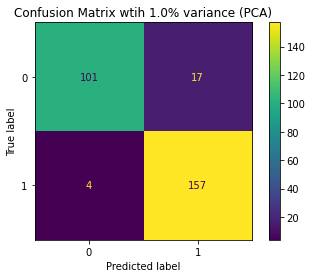

time: 165 ms (started: 2022-05-02 04:00:08 +00:00)


In [ ]:
# tune_exp81[-1]["model"]

best_item = tune_exp81[-1]
x_train_sc23, x_test_sc23 = feature_scale(best_item["x_train_"], best_item["x_test_"])

disp = plot_confusion_matrix(best_item["model"], x_test_sc23, best_item["y_test_"])
plt.title("Confusion Matrix wtih " + str(best_item['variance_']) + "% variance (PCA)")
confM = disp.confusion_matrix
plt.show()

In [ ]:
print("PCA variance: 100% LBP (16,2)")
row1_sum = np.array(confM[0]).sum()
row2_sum = np.array(confM[1]).sum()

acc_Normal = (confM[0][0] / row1_sum)*100
acc_Tumor = (confM[1][1] / row2_sum)*100

print(f"Normal accuracy: {acc_Normal}, Tumor accuracy: {acc_Tumor}")
print("")

PCA variance: 100% LBP (16,2)
Normal accuracy: 88.46153846153845, Tumor accuracy: 88.40579710144928

time: 10.8 ms (started: 2022-04-27 03:27:39 +00:00)


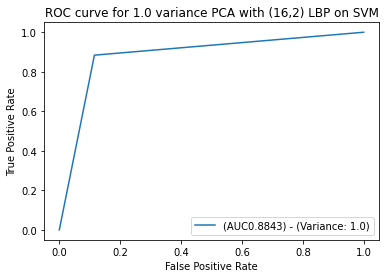

time: 221 ms (started: 2022-04-27 03:27:39 +00:00)


In [ ]:
y_pred = best_item['model'].predict(x_test_sc23)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.round_(auc(fpr, tpr), decimals=4)
txt = "(AUC" + str(roc_auc) + ") - (Variance: " + str(best_item["variance_"]) + ")"
plt.plot(fpr, tpr, label=txt)

plt.title("ROC curve for " + str(tune_exp162[-1]['variance_']) + " variance PCA with (16,2) LBP on SVM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

In [ ]:
target_names = ['Normal', 'Tumor']

print("Classification report for " + str(best_item['variance_']))

y_pred = best_item['model'].predict(x_test_sc23)

print(classification_report(best_item["y_test_"], y_pred, target_names=target_names))
print("\n\n")

Classification report for 1.0
              precision    recall  f1-score   support

      Normal       0.85      0.88      0.87        52
       Tumor       0.91      0.88      0.90        69

    accuracy                           0.88       121
   macro avg       0.88      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121




time: 32.2 ms (started: 2022-04-27 03:27:39 +00:00)


# Save Models

In [ ]:
import pickle

time: 1.29 ms (started: 2022-04-27 03:27:39 +00:00)


In [ ]:
SAVE_DIR = ROOT_DIR + "/saved_models/"

# no img aug
FILE_NAME = "svm_mri_lbp_pca_noAug.pkl"

# img aug
# FILE_NAME = "svm_mri_lbp_pca_Aug.pkl"

with open(SAVE_DIR+FILE_NAME,'wb') as f:
    pickle.dump(best_item['model'],f)

time: 19 ms (started: 2022-04-27 03:27:39 +00:00)
